In [2829]:
import pandas as pd
import numpy as np
from feature_engine.imputation import MeanMedianImputer,CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.transformation import PowerTransformer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from feature_engine.encoding import MeanEncoder
woe = MeanEncoder()
from sklearn.metrics import roc_auc_score
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


In [2830]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
variable_data = pd.read_csv("VariableDescription.csv")

In [2831]:
train_data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [2832]:
test_data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


In [2833]:
train_data.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code', 'Claim'],
      dtype='object')

In [2834]:
test_data.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object')

In [2835]:
test_data.shape, train_data.shape

((3069, 13), (7160, 14))

In [2836]:
variable_data

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


In [2837]:
# first we want to correct the columns so that they become lower cased and remove spaces
train_data.columns = train_data.columns.str.lower().str.replace(" ", "_")

test_data.columns = test_data.columns.str.lower().str.replace(" ", "_")

# check if thy are corrected
train_data.columns

Index(['customer_id', 'yearofobservation', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy',
       'numberofwindows', 'geo_code', 'claim'],
      dtype='object')

In [2838]:
# we describe our data to check if there any missing values
train_data.describe()

,yearofobservation,insured_period,residential,building_dimension,building_type,date_of_occupancy,claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [2839]:
#drop any duplicated
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

In [2840]:
# we use is null to see
train_data.isnull().sum()

customer_id             0
yearofobservation       0
insured_period          0
residential             0
building_painted        0
building_fenced         0
garden                  7
settlement              0
building_dimension    106
building_type           0
date_of_occupancy     508
numberofwindows         0
geo_code              102
claim                   0
dtype: int64

In [2841]:
# we can also check the datatype to see the column of the missing values this will help on imputation method
train_data.dtypes

customer_id            object
yearofobservation       int64
insured_period        float64
residential             int64
building_painted       object
building_fenced        object
garden                 object
settlement             object
building_dimension    float64
building_type           int64
date_of_occupancy     float64
numberofwindows        object
geo_code               object
claim                   int64
dtype: object

In [2842]:
train_data.corr()

C:\Users\HP\AppData\Local\Temp\ipykernel_1028\1402113604.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corr()


,yearofobservation,insured_period,residential,building_dimension,building_type,date_of_occupancy,claim
yearofobservation,1.000000,0.025434,-0.040391,0.009128,0.005490,-0.029492,-0.016367
insured_period,0.025434,1.000000,-0.037620,0.007473,-0.017811,-0.003445,0.088715
residential,-0.040391,-0.037620,1.000000,0.057481,0.334039,-0.042058,0.063509
building_dimension,0.009128,0.007473,0.057481,1.000000,0.007935,0.207624,0.297089
building_type,0.005490,-0.017811,0.334039,0.007935,1.000000,-0.146608,0.112168
date_of_occupancy,-0.029492,-0.003445,-0.042058,0.207624,-0.146608,1.000000,0.019170
claim,-0.016367,0.088715,0.063509,0.297089,0.112168,0.019170,1.000000


In [2843]:
# for garden and geocode we going to use countfrequencey encoder


ci = CategoricalImputer(imputation_method="frequent")
train_data[["garden", "geo_code"]] = ci.fit_transform(
    train_data[["garden", "geo_code"]]
)
test_data[["garden", "geo_code"]] = ci.fit_transform(test_data[["garden", "geo_code"]])



mmi = MeanMedianImputer(imputation_method="median")
train_data[["building_dimension", "date_of_occupancy"]] = mmi.fit_transform(
    train_data[["building_dimension", "date_of_occupancy"]]
)
test_data[["building_dimension", "date_of_occupancy"]] = mmi.fit_transform(
    test_data[["building_dimension", "date_of_occupancy"]]
)

In [2844]:
# check if there still any missing
train_data.isnull().sum()

customer_id           0
yearofobservation     0
insured_period        0
residential           0
building_painted      0
building_fenced       0
garden                0
settlement            0
building_dimension    0
building_type         0
date_of_occupancy     0
numberofwindows       0
geo_code              0
claim                 0
dtype: int64

In [2845]:
test_data.shape, train_data.shape

((3069, 13), (7160, 14))

In [2846]:
# we need to rename columns year and windows

train_data.rename(
    columns={
        "yearofobservation": "year_of_observation",
        "numberofwindows": "number_of_windows",
    },
    inplace=True,
)
test_data.rename(
    columns={
        "yearofobservation": "year_of_observation",
        "numberofwindows": "number_of_windows",
    },
    inplace=True,
)
# check
test_data.columns

Index(['customer_id', 'year_of_observation', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy',
       'number_of_windows', 'geo_code'],
      dtype='object')

In [2847]:
train_data.number_of_windows = train_data.number_of_windows.str.replace(
    "   .", "0"
).str.replace(">=10", "10")

test_data.number_of_windows = test_data.number_of_windows.str.replace(
    "   .", "0"
).str.replace(">=10", "10")

C:\Users\HP\AppData\Local\Temp\ipykernel_1028\2230402883.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data.number_of_windows = train_data.number_of_windows.str.replace(
C:\Users\HP\AppData\Local\Temp\ipykernel_1028\2230402883.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data.number_of_windows = test_data.number_of_windows.str.replace(


In [2848]:
# check if windows is now corrected
train_data.number_of_windows.unique()

array(['0', '4', '3', '2', '5', '10', '6', '7', '9', '8', '1'],
      dtype=object)

In [2849]:
#change the date_occupancy to integer
train_data.date_of_occupancy=train_data.date_of_occupancy.astype(int)
test_data.date_of_occupancy=test_data.date_of_occupancy.astype(int)

#change window dtype to integer
train_data.number_of_windows = train_data.number_of_windows.astype(int)
test_data.number_of_windows = test_data.number_of_windows.astype(int)

In [2850]:
# set date as integer
train_data[["year_of_observation", "date_of_occupancy"]] = train_data[
    ["year_of_observation", "date_of_occupancy"]
].astype('object')
test_data[["year_of_observation", "date_of_occupancy"]] = test_data[
    ["year_of_observation", "date_of_occupancy"]
].astype('object')
train_data.dtypes

customer_id             object
year_of_observation     object
insured_period         float64
residential              int64
building_painted        object
building_fenced         object
garden                  object
settlement              object
building_dimension     float64
building_type            int64
date_of_occupancy       object
number_of_windows        int32
geo_code                object
claim                    int64
dtype: object

In [2851]:
test_data.shape, train_data.shape

((3069, 13), (7160, 14))

In [2852]:
# i will assume everything happen on the fist day of the month
train_data[["year_of_observation", "date_of_occupancy"]] = train_data[
    ["year_of_observation", "date_of_occupancy"]
].apply(lambda x: pd.to_datetime(x, format="%Y", errors="coerce"))
test_data[["year_of_observation", "date_of_occupancy"]] = test_data[
    ["year_of_observation", "date_of_occupancy"]
].apply(lambda x: pd.to_datetime(x, format="%Y", errors="coerce"))
test_data.year_of_observation.dtypes

dtype('<M8[ns]')

In [2853]:
train_data.dropna(axis=0,inplace=True)
test_data.dropna(axis=0,inplace=True)

In [2854]:
train_data.isnull().sum()

customer_id            0
year_of_observation    0
insured_period         0
residential            0
building_painted       0
building_fenced        0
garden                 0
settlement             0
building_dimension     0
building_type          0
date_of_occupancy      0
number_of_windows      0
geo_code               0
claim                  0
dtype: int64

In [2855]:
train_data.head()

,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,date_of_occupancy,number_of_windows,geo_code,claim
0,H14663,2013-01-01,1.0,0,N,V,V,U,290.0,1,1960-01-01,0,1053,0
1,H2037,2015-01-01,1.0,0,V,N,O,R,490.0,1,1850-01-01,4,1053,0
2,H3802,2014-01-01,1.0,0,N,V,V,U,595.0,1,1960-01-01,0,1053,0
3,H3834,2013-01-01,1.0,0,V,V,V,U,2840.0,1,1960-01-01,0,1053,0
4,H5053,2014-01-01,1.0,0,V,N,O,R,680.0,1,1800-01-01,3,1053,0


In [2856]:
train_data.columns


Index(['customer_id', 'year_of_observation', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy',
       'number_of_windows', 'geo_code', 'claim'],
      dtype='object')

In [2857]:
#we need to encode the categorical values
#for painted,fenced,garden,settlement we use categorical encode


oe = OrdinalEncoder(encoding_method='arbitrary')

train_data[
    [
        'building_painted', 'building_fenced', 'garden', 'settlement'
    ]
] = oe.fit_transform(train_data[
    [
        'building_painted', 'building_fenced', 'garden', 'settlement'
    ]
])

test_data[
    [
        'building_painted', 'building_fenced', 'garden', 'settlement'
    ]
] = oe.fit_transform(test_data[
    [
        'building_painted', 'building_fenced', 'garden', 'settlement'
    ]
])

test_data.head()

,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,date_of_occupancy,number_of_windows,geo_code
0,H11920,2013-01-01,1.000000,0,0,0,0,0,300.0,1,1960-01-01,3,3310
1,H11921,2016-01-01,0.997268,0,0,0,0,0,300.0,1,1960-01-01,3,3310
2,H9805,2013-01-01,0.369863,0,0,1,1,1,790.0,1,1960-01-01,0,3310
3,H7493,2014-01-01,1.000000,0,0,0,0,0,1405.0,1,2004-01-01,3,3321
4,H7494,2016-01-01,1.000000,0,0,0,0,0,1405.0,1,2004-01-01,3,3321


In [2858]:
test_data.shape, train_data.shape

((3069, 13), (7152, 14))

In [2859]:
#discretization of the period

ef =EqualFrequencyDiscretiser()

train_data[['insured_period']] = ef.fit_transform(train_data[['insured_period']])

test_data[['insured_period']] = ef.fit_transform(test_data[['insured_period']])

In [2860]:
test_data.shape, train_data.shape

((3069, 13), (7152, 14))

In [2861]:
#need to create new features
train_data = train_data.assign(
    year_occupied_before_insurance = train_data.year_of_observation.dt.year - train_data.date_of_occupancy.dt.year
)

test_data = test_data.assign(
    year_occupied_before_insurance = test_data.year_of_observation.dt.year - test_data.date_of_occupancy.dt.year
)
test_data.head()

,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,date_of_occupancy,number_of_windows,geo_code,year_occupied_before_insurance
0,H11920,2013-01-01,2,0,0,0,0,0,300.0,1,1960-01-01,3,3310,53
1,H11921,2016-01-01,1,0,0,0,0,0,300.0,1,1960-01-01,3,3310,56
2,H9805,2013-01-01,0,0,0,1,1,1,790.0,1,1960-01-01,0,3310,53
3,H7493,2014-01-01,2,0,0,0,0,0,1405.0,1,2004-01-01,3,3321,10
4,H7494,2016-01-01,2,0,0,0,0,0,1405.0,1,2004-01-01,3,3321,12


In [2862]:
test_data.head()

,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,date_of_occupancy,number_of_windows,geo_code,year_occupied_before_insurance
0,H11920,2013-01-01,2,0,0,0,0,0,300.0,1,1960-01-01,3,3310,53
1,H11921,2016-01-01,1,0,0,0,0,0,300.0,1,1960-01-01,3,3310,56
2,H9805,2013-01-01,0,0,0,1,1,1,790.0,1,1960-01-01,0,3310,53
3,H7493,2014-01-01,2,0,0,0,0,0,1405.0,1,2004-01-01,3,3321,10
4,H7494,2016-01-01,2,0,0,0,0,0,1405.0,1,2004-01-01,3,3321,12


In [2863]:
train_data.isnull().sum()

customer_id                       0
year_of_observation               0
insured_period                    0
residential                       0
building_painted                  0
building_fenced                   0
garden                            0
settlement                        0
building_dimension                0
building_type                     0
date_of_occupancy                 0
number_of_windows                 0
geo_code                          0
claim                             0
year_occupied_before_insurance    0
dtype: int64

In [2864]:
train_data.dtypes

customer_id                               object
year_of_observation               datetime64[ns]
insured_period                             int64
residential                                int64
building_painted                           int64
building_fenced                            int64
garden                                     int64
settlement                                 int64
building_dimension                       float64
building_type                              int64
date_of_occupancy                 datetime64[ns]
number_of_windows                          int32
geo_code                                  object
claim                                      int64
year_occupied_before_insurance             int64
dtype: object

In [2865]:
#Create total building dimension per geocode
building_dimension_per_geocode = train_data.groupby('geo_code')['building_dimension'].mean().reset_index()
building_dimension_per_geocode.rename(columns={'building_dimension': 'dimension_per_geocode'}, inplace=True)
train_data = train_data.merge(building_dimension_per_geocode, on='geo_code', how='left')

building_dimension_per_geocode = test_data.groupby('geo_code')['building_dimension'].mean().reset_index()
building_dimension_per_geocode.rename(columns={'building_dimension': 'building_dimension_per_geocode'}, inplace=True)
test_data = test_data.merge(building_dimension_per_geocode, on='geo_code', how='left')

#Create total buidling dimension per geocode
sum_building_dimension_per_geocode = train_data.groupby('geo_code')['building_dimension'].sum().reset_index()
sum_building_dimension_per_geocode.rename(columns={'building_dimension': 'sum_dimension_per_geocode'}, inplace=True)
train_data = train_data.merge(sum_building_dimension_per_geocode, on='geo_code', how='left')

sum_building_dimension_per_geocode = test_data.groupby('geo_code')['building_dimension'].sum().reset_index()
sum_building_dimension_per_geocode.rename(columns={'building_dimension': 'sum_dimension_per_geocode'}, inplace=True)
test_data = test_data.merge(sum_building_dimension_per_geocode, on='geo_code', how='left')

##Create total buidling type per geocode
#sum_insured_period_per_geocode = train_data.groupby('geo_code')['insured_period'].sum().reset_index()
#sum_insured_period_per_geocode.rename(columns={'insured_period': 'sum_type_per_geocode'}, inplace=True)
#train_data = train_data.merge(sum_insured_period_per_geocode, on='geo_code', how='left')
#
#sum_insured_period_per_geocode = test_data.groupby('geo_code')['insured_period'].sum().reset_index()
#sum_insured_period_per_geocode.rename(columns={'insured_period': 'sum_type_per_geocode'}, inplace=True)
#test_data = test_data.merge(sum_insured_period_per_geocode, on='geo_code', how='left')



# Calculate total insured period per Geo Code
total_insured_period_per_geocode = train_data.groupby('geo_code')['insured_period'].sum().reset_index()
total_insured_period_per_geocode.rename(columns={'insured_period': 'total_insured_period_per_geocode'}, inplace=True)
train_data = train_data.merge(total_insured_period_per_geocode, on='geo_code', how='left')


total_insured_period_per_geocode = test_data.groupby('geo_code')['insured_period'].sum().reset_index()
total_insured_period_per_geocode.rename(columns={'insured_period': 'total_insured_period_per_geocode'}, inplace=True)
test_data = test_data.merge(total_insured_period_per_geocode, on='geo_code', how='left')




In [2866]:
train_data.columns

Index(['customer_id', 'year_of_observation', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy',
       'number_of_windows', 'geo_code', 'claim',
       'year_occupied_before_insurance', 'dimension_per_geocode',
       'sum_dimension_per_geocode', 'total_insured_period_per_geocode'],
      dtype='object')

In [2867]:
train_data.isnull().sum()

customer_id                         0
year_of_observation                 0
insured_period                      0
residential                         0
building_painted                    0
building_fenced                     0
garden                              0
settlement                          0
building_dimension                  0
building_type                       0
date_of_occupancy                   0
number_of_windows                   0
geo_code                            0
claim                               0
year_occupied_before_insurance      0
dimension_per_geocode               0
sum_dimension_per_geocode           0
total_insured_period_per_geocode    0
dtype: int64

In [2868]:
#There seemed to be missing on year_occupied so i wanted to
#train_data['year_occupied_before_insurance'] = train_data['year_occupied_before_insurance'].fillna(0)
#test_data['year_occupied_before_insurance'] = test_data['year_occupied_before_insurance'].fillna(0)

#Create Average dimension by type feautre
average_size_by_type = train_data.groupby('building_type')['building_dimension'].mean().reset_index()
average_size_by_type.rename(columns={'building_dimension': 'average_size_by_type'}, inplace=True)
train_data = train_data.merge(average_size_by_type, on='building_type', how='left')
train_data['size_ratio_to_average'] = train_data['building_dimension'] / train_data['average_size_by_type']

average_size_by_type = test_data.groupby('building_type')['building_dimension'].mean().reset_index()
average_size_by_type.rename(columns={'building_dimension': 'average_size_by_type'}, inplace=True)
test_data = test_data.merge(average_size_by_type, on='building_type', how='left')
test_data['size_ratio_to_average'] = test_data['building_dimension'] / test_data['average_size_by_type']





##Create building type per insured period
#average_period_per_type = train_data.groupby('building_type')['insured_period'].mean().reset_index()
#average_period_per_type.rename(columns={'insured_period': 'average_period_per_type'}, inplace=True)
#train_data = train_data.merge(average_period_per_type, on='building_type', how='left')
#train_data['period_ratio_to_average'] = train_data['insured_period'] / train_data['average_period_per_type']
#
#average_period_per_type = test_data.groupby('building_type')['insured_period'].mean().reset_index()
#average_period_per_type.rename(columns={'insured_period': 'average_period_per_type'}, inplace=True)
#test_data = test_data.merge(average_period_per_type, on='building_type', how='left')
#test_data['period_ratio_to_average'] = test_data['insured_period'] / test_data['average_period_per_type']



#Create a window feature
train_data = train_data.assign(
    total_window_area = train_data['building_dimension'] *  train_data['number_of_windows'].astype(int)
    )
test_data = test_data.assign(
    total_window_area = test_data['building_dimension'] *  test_data['number_of_windows'].astype(int)
    )

#Create a window feature per type
train_data = train_data.assign(
    total_window_per_type = train_data['building_type'] *  train_data['number_of_windows'].astype(int) 
)
test_data = test_data.assign(
    total_window_per_type = test_data['building_type'] *  test_data['number_of_windows'].astype(int)
    )

train_data.head()

,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,...,geo_code,claim,year_occupied_before_insurance,dimension_per_geocode,sum_dimension_per_geocode,total_insured_period_per_geocode,average_size_by_type,size_ratio_to_average,total_window_area,total_window_per_type
0,H14663,2013-01-01,2,0,0,0,0,0,290.0,1,...,1053,0,53,979.0,4895.0,10,1877.061916,0.154497,0.0,0
1,H2037,2015-01-01,2,0,1,1,1,1,490.0,1,...,1053,0,165,979.0,4895.0,10,1877.061916,0.261046,1960.0,4
2,H3802,2014-01-01,2,0,0,0,0,0,595.0,1,...,1053,0,54,979.0,4895.0,10,1877.061916,0.316985,0.0,0
3,H3834,2013-01-01,2,0,1,0,0,0,2840.0,1,...,1053,0,53,979.0,4895.0,10,1877.061916,1.513003,0.0,0
4,H5053,2014-01-01,2,0,1,1,1,1,680.0,1,...,1053,0,214,979.0,4895.0,10,1877.061916,0.362268,2040.0,3


In [2869]:
train_data.columns

Index(['customer_id', 'year_of_observation', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy',
       'number_of_windows', 'geo_code', 'claim',
       'year_occupied_before_insurance', 'dimension_per_geocode',
       'sum_dimension_per_geocode', 'total_insured_period_per_geocode',
       'average_size_by_type', 'size_ratio_to_average', 'total_window_area',
       'total_window_per_type'],
      dtype='object')

In [2870]:
# create lag features of building_dimension in the previous year)
train_data['building_dimension_lagged'] = train_data.groupby('year_of_observation')['building_dimension'].shift()
test_data['building_dimension_lagged'] = test_data.groupby('year_of_observation')['building_dimension'].shift()


#create lag feature of Insured period
train_data['insured_period_lagged'] = train_data.groupby('year_of_observation')['insured_period'].shift()
test_data['insured_period_lagged'] = test_data.groupby('year_of_observation')['insured_period'].shift()

# calculate rolling mean  3-year window
train_data['dimension_year_rolling_mean'] = train_data.groupby('year_of_observation')['building_dimension'].rolling(window=3).mean().reset_index(level=0, drop=True)
train_data['dimension_occupancy_rolling_mean'] = train_data.groupby('date_of_occupancy')['building_dimension'].rolling(window=3).mean().reset_index(level=0, drop=True)

test_data['dimension_year_rolling_mean'] = test_data.groupby('year_of_observation')['building_dimension'].rolling(window=3).mean().reset_index(level=0, drop=True)
test_data['dimension_occupancy_rolling_mean'] = test_data.groupby('date_of_occupancy')['building_dimension'].rolling(window=3).mean().reset_index(level=0, drop=True)



In [2871]:
#using log transformer on numeric variables
lt = PowerTransformer()
train_data[
    [
       'building_dimension','year_occupied_before_insurance'
    ]
] = lt.fit_transform(
   train_data[
    [
       'building_dimension','year_occupied_before_insurance'
    ]
] 
)

test_data[
    [
       'building_dimension','year_occupied_before_insurance'
    ]
] = lt.fit_transform(
   test_data[
    [
       'building_dimension','year_occupied_before_insurance'
    ]
] 
)
test_data.head()


,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,...,sum_dimension_per_geocode,total_insured_period_per_geocode,average_size_by_type,size_ratio_to_average,total_window_area,total_window_per_type,building_dimension_lagged,insured_period_lagged,dimension_year_rolling_mean,dimension_occupancy_rolling_mean
0,H11920,2013-01-01,2,0,0,0,0,0,17.320508,1,...,1390.0,3,1568.842657,0.191224,900.0,3,NaN,NaN,NaN,NaN
1,H11921,2016-01-01,1,0,0,0,0,0,17.320508,1,...,1390.0,3,1568.842657,0.191224,900.0,3,NaN,NaN,NaN,NaN
2,H9805,2013-01-01,0,0,0,1,1,1,28.106939,1,...,1390.0,3,1568.842657,0.503556,0.0,0,300.0,2.0,NaN,463.333333
3,H7493,2014-01-01,2,0,0,0,0,0,37.483330,1,...,2810.0,4,1568.842657,0.895565,4215.0,3,NaN,NaN,NaN,NaN
4,H7494,2016-01-01,2,0,0,0,0,0,37.483330,1,...,2810.0,4,1568.842657,0.895565,4215.0,3,300.0,1.0,NaN,NaN


In [2872]:
test_data.shape, train_data.shape

((3069, 25), (7152, 26))

In [2873]:
#Checking the missing values
train_data.loc[train_data.isnull().any(axis = 1)]

,customer_id,year_of_observation,insured_period,residential,building_painted,building_fenced,garden,settlement,building_dimension,building_type,...,sum_dimension_per_geocode,total_insured_period_per_geocode,average_size_by_type,size_ratio_to_average,total_window_area,total_window_per_type,building_dimension_lagged,insured_period_lagged,dimension_year_rolling_mean,dimension_occupancy_rolling_mean
0,H14663,2013-01-01,2,0,0,0,0,0,17.029386,1,...,4895.0,10,1877.061916,0.154497,0.0,0,NaN,NaN,NaN,NaN
1,H2037,2015-01-01,2,0,1,1,1,1,22.135944,1,...,4895.0,10,1877.061916,0.261046,1960.0,4,NaN,NaN,NaN,NaN
2,H3802,2014-01-01,2,0,0,0,0,0,24.392622,1,...,4895.0,10,1877.061916,0.316985,0.0,0,NaN,NaN,NaN,NaN
3,H3834,2013-01-01,2,0,1,0,0,0,53.291650,1,...,4895.0,10,1877.061916,1.513003,0.0,0,290.0,2.0,NaN,1241.666667
4,H5053,2014-01-01,2,0,1,1,1,1,26.076810,1,...,4895.0,10,1877.061916,0.362268,2040.0,3,595.0,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6069,H15821,2014-01-01,2,0,1,1,1,1,83.803341,1,...,7023.0,2,1877.061916,3.741486,21069.0,3,2233.0,1.0,3485.333333,NaN
6235,H19608,2014-01-01,0,0,1,1,1,1,22.360680,3,...,84267.0,107,1842.366667,0.271390,1500.0,9,6280.0,1.0,3493.333333,NaN
6291,H14972,2015-01-01,2,1,1,1,1,1,28.705400,3,...,81790.0,50,1842.366667,0.447251,4120.0,15,550.0,2.0,1773.666667,NaN
6800,H15250,2014-01-01,2,1,1,1,1,1,31.622777,3,...,42712.0,44,1842.366667,0.542780,6000.0,18,1176.0,2.0,1492.000000,NaN


In [2874]:
train_data.isnull().sum()
#I should then use some transformer to fix all those missing

customer_id                           0
year_of_observation                   0
insured_period                        0
residential                           0
building_painted                      0
building_fenced                       0
garden                                0
settlement                            0
building_dimension                    0
building_type                         0
date_of_occupancy                     0
number_of_windows                     0
geo_code                              0
claim                                 0
year_occupied_before_insurance        0
dimension_per_geocode                 0
sum_dimension_per_geocode             0
total_insured_period_per_geocode      0
average_size_by_type                  0
size_ratio_to_average                 0
total_window_area                     0
total_window_per_type                 0
building_dimension_lagged             5
insured_period_lagged                 5
dimension_year_rolling_mean          10


In [2875]:
from feature_engine.datetime import DatetimeFeatures
def create_date_features_and_concat(
        train:pd.DataFrame,

):
    dtf = DatetimeFeatures(features_to_extract = ["year"],drop_original=False)
    train = dtf.fit_transform(train)
    return train

In [2876]:
#Using function to create the date feautures
train_data = create_date_features_and_concat(train_data
)

test_data = create_date_features_and_concat(test_data
)
train_data.drop(
    columns=['year_of_observation','date_of_occupancy'],inplace=True
)
test_data.drop(
    columns=['year_of_observation','date_of_occupancy'],inplace=True
)



In [2877]:
#filling in missings with 0
train_data['dimension_occupancy_rolling_mean'] = train_data['dimension_occupancy_rolling_mean'].fillna(0)
test_data['dimension_occupancy_rolling_mean'] = test_data['dimension_occupancy_rolling_mean'].fillna(0)

In [2878]:
#feature creation
cf = CyclicalFeatures(variables=['year_occupied_before_insurance','building_dimension','building_type','total_insured_period_per_geocode'])
train_data = cf.fit_transform(train_data)
test_data = cf.fit_transform(test_data)

In [2879]:
#Seperate code into X and y variable and
X=train_data.drop(["claim","customer_id"],axis=1)
X_t=test_data.drop(["customer_id",],axis=1)
y=train_data["claim"]

In [2880]:
X.shape , X_t.shape

((7152, 32), (3069, 32))

In [2881]:
#encode the geocode feature
X.drop(columns=['geo_code','garden','settlement','building_painted','building_fenced'],inplace=True)
X_t.drop(columns=['geo_code','garden','settlement','building_painted','building_fenced'],inplace=True)

In [2882]:
#Try scaling maybe the min max scaler or standardization


In [2883]:
#spliting our data intro train and testing data
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=42)

In [2884]:
X_train.head()

,insured_period,residential,building_dimension,building_type,number_of_windows,year_occupied_before_insurance,dimension_per_geocode,sum_dimension_per_geocode,total_insured_period_per_geocode,average_size_by_type,...,year_of_observation_year,date_of_occupancy_year,year_occupied_before_insurance_sin,year_occupied_before_insurance_cos,building_dimension_sin,building_dimension_cos,building_type_sin,building_type_cos,total_insured_period_per_geocode_sin,total_insured_period_per_geocode_cos
2843,2,1,54.772256,3,0,5.744563,2446.140351,139430.0,89,1842.366667,...,2013,1980,0.896204,-0.443642,0.691362,-0.722509,-1.000000e+00,-1.836970e-16,0.995083,0.099046
577,1,1,46.754679,4,0,6.000000,1451.588235,24677.0,25,1974.755776,...,2016,1980,0.852554,-0.522640,0.896363,-0.443321,-2.449294e-16,1.000000e+00,0.401695,0.915773
59,2,0,42.918527,1,0,5.196152,1793.416667,21521.0,23,1877.061916,...,2015,1988,0.964878,-0.262700,0.957459,-0.288570,1.000000e+00,6.123234e-17,0.371197,0.928554
3165,2,0,26.267851,1,0,5.656854,1990.318182,43787.0,37,1877.061916,...,2012,1980,0.909525,-0.415650,0.908865,0.417091,1.000000e+00,6.123234e-17,0.574329,0.818625
787,2,0,43.817805,1,4,6.082763,1703.500000,44291.0,34,1877.061916,...,2015,1978,0.836902,-0.547352,0.945464,-0.325727,1.000000e+00,6.123234e-17,0.533032,0.846095


In [2885]:
#paramemeter for the model
parameters = {
            'nthread':4,
            'n_estimators':50,
            'learning_rate':0.036,
            'num_leaves':30,
            'colsample_bytree':0.9497036,
            'subsample':0.8715623,
            'max_depth':0,
            'reg_alpha':0,
            'reg_lambda':0.0735294,
            'min_split_gain':0.0222415,
            'min_child_weight':39.3259775,
            'silent':-1,
            'verbose':-1,
            'bagging_seed':5,
            'feature_fraction': 0.957,
            'bagging_fraction': 0.956,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc'}

In [2886]:

train_data_ = lgb.Dataset(X_train, label=y_train)
test_data_ = lgb.Dataset(X_test, label=y_test)


clf =lgb.train(params=parameters, 
                train_set=train_data_,
                valid_sets=[test_data_])

# Make predictions on the test set
y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)

# Evaluate the model using ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC score: {roc_auc:.4f}')

ROC AUC score: 0.7138


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [3044]:

NFOLDS = 5

folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True,random_state=42)


columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf_fold = lgb.train(parameters, dtrain, valid_sets = [dvalid])
    
    feature_importances[f'fold_{fold_n + 1}'] = clf_fold.feature_importance()
    
    y_pred_valid = clf_fold.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf_fold.predict(X_test) / NFOLDS
    
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 | AUC: 0.7013030182156629
Fold 2 | AUC: 0.678415713779196
Fold 3 | AUC: 0.7139598337334401
Fold 4 | AUC: 0.7489997332622033
Fold 5 | AUC: 0.7072357568044894

Mean AUC = 0.7099828111589983
Out of folds AUC = 0.709038985403317


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


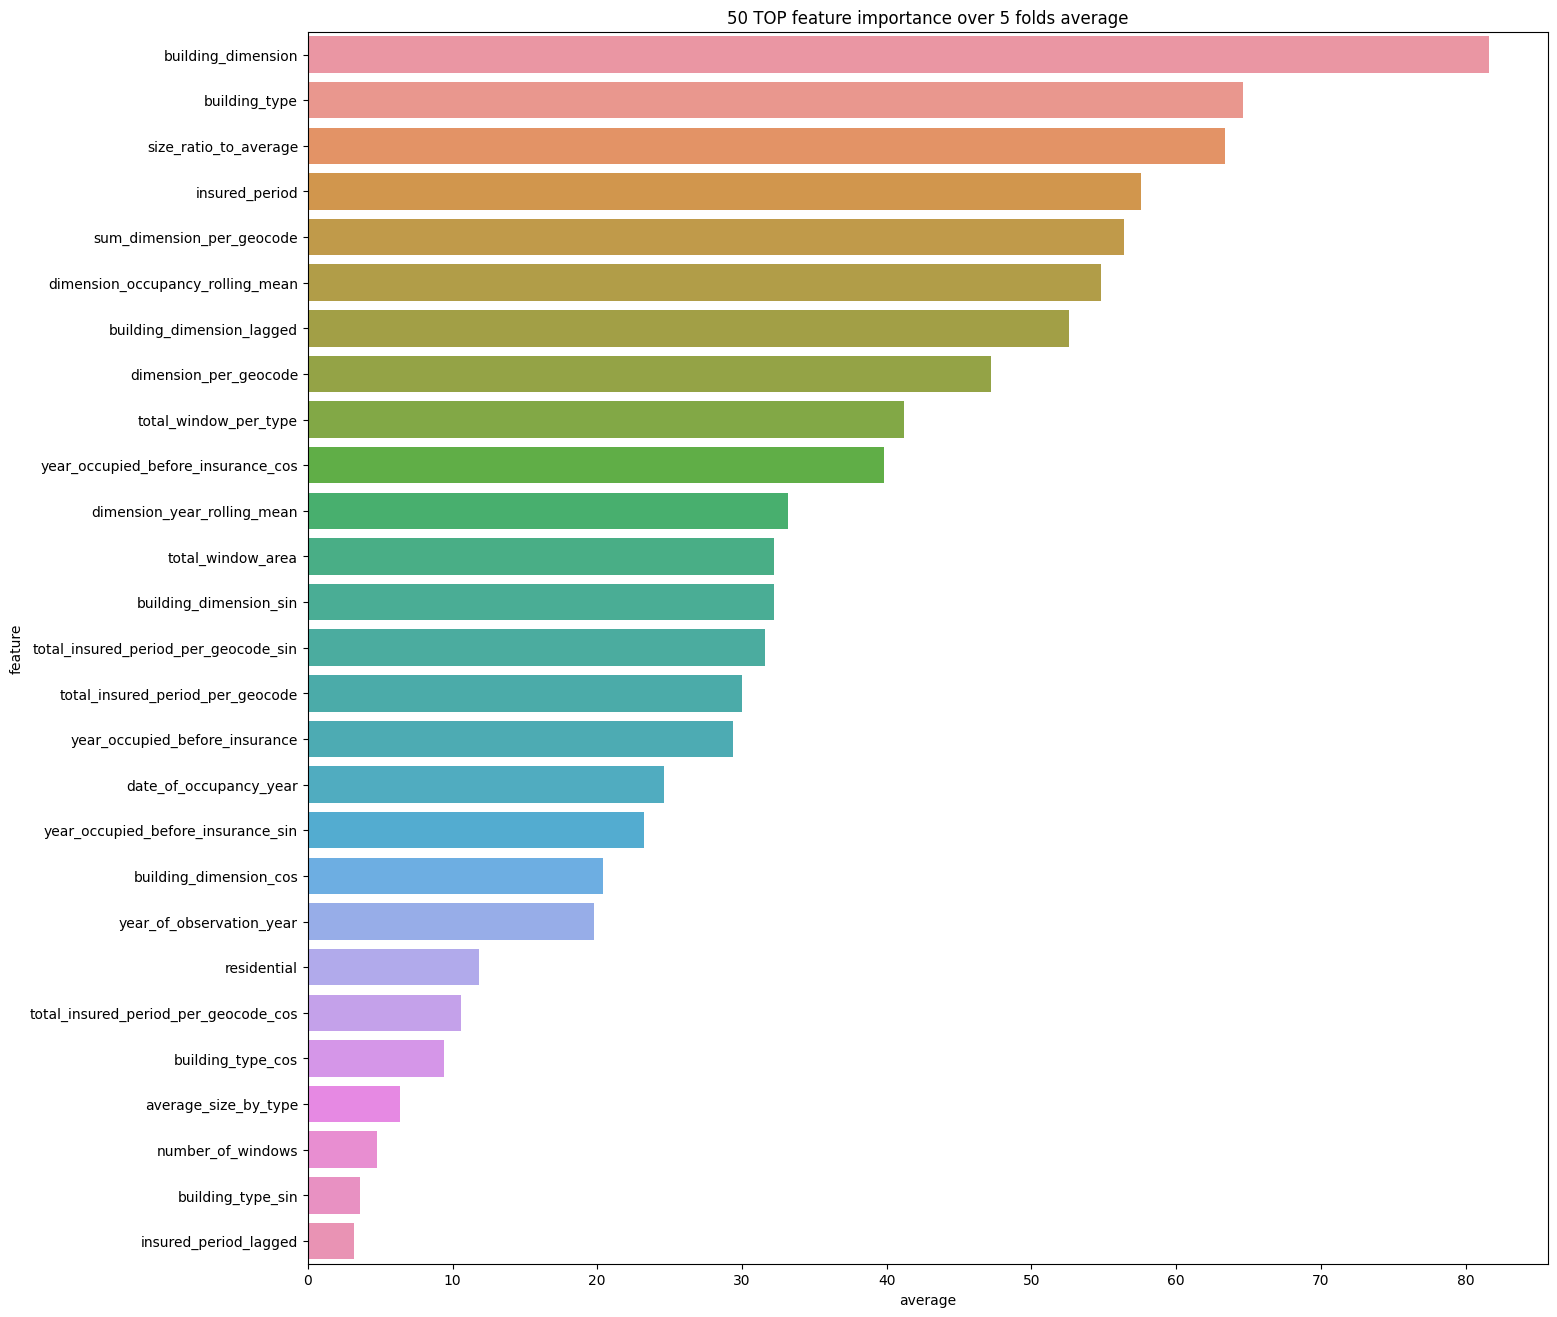

In [3045]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
#feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [3046]:
'''def model_score(model):
    rtr = model.predict_proba(X_train)
    rte = model.predict_proba(X_test)
    
    train_auc = roc_auc_score(y_train, [x[1] for x in rtr])
    test_auc = roc_auc_score(y_test, [x[1] for x in rte])
    print('Training data AUC: {} \t Validation AUC: {}'.format(train_auc, test_auc))
    return test_auc


kf = StratifiedKFold(n_splits=5, shuffle=False)
scores, preds = [], []
j = 1

#ct = CatBoostClassifier(n_estimators = 100, eval_metric='AUC', random_state=5, thread_count=-1, max_depth=5, use_best_model=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf.fit(X_train, y_train)

    print(f'Split trained: {j}')

    score = model_score(clf)
    pred = clf.predict_proba(X_test)  # prediction of the test data
    pred = [x[1] for x in pred]
    
    scores.append(score)
    preds.append(pred)
    j += 1

print(np.mean(scores))'''

"def model_score(model):\n    rtr = model.predict_proba(X_train)\n    rte = model.predict_proba(X_test)\n    \n    train_auc = roc_auc_score(y_train, [x[1] for x in rtr])\n    test_auc = roc_auc_score(y_test, [x[1] for x in rte])\n    print('Training data AUC: {} \t Validation AUC: {}'.format(train_auc, test_auc))\n    return test_auc\n\n\nkf = StratifiedKFold(n_splits=5, shuffle=False)\nscores, preds = [], []\nj = 1\n\n#ct = CatBoostClassifier(n_estimators = 100, eval_metric='AUC', random_state=5, thread_count=-1, max_depth=5, use_best_model=True)\n\nfor train_index, test_index in kf.split(X, y):\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n\n    clf.fit(X_train, y_train)\n\n    print(f'Split trained: {j}')\n\n    score = model_score(clf)\n    pred = clf.predict_proba(X_test)  # prediction of the test data\n    pred = [x[1] for x in pred]\n    \n    scores.append(score)\n    preds.append(pred)\n    j += 

In [3051]:
# Make predictions on the test set using the best LightGBM model
y_pred_c = clf.predict(X_t, num_iteration=clf.best_iteration)


In [3052]:
test_id = test_data['customer_id']
d = {"customer_id": test_id, 'claim':y_pred_c}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["customer_id", 'claim']]

In [3053]:
test_predictions

,customer_id,claim
0,H11920,0.092945
1,H11921,0.087936
2,H9805,0.110626
3,H7493,0.144753
4,H7494,0.148573
...,...,...
3064,H11583,0.259975
3065,H11720,0.183952
3066,H11721,0.146315
3067,H12408,0.198211


In [3050]:
#saving the file
test_predictions.to_csv('2023_first_submission_best.csv', index=False)